Total iterations: 5
Iteration 0: 1 communities — sizes: [34]
Iteration 1: 2 communities — sizes: [18, 16]
Iteration 2: 3 communities — sizes: [3, 15, 16]
Iteration 3: 4 communities — sizes: [3, 15, 5, 11]
Iteration 4: 5 communities — sizes: [2, 1, 15, 5, 11]


/tmp/ipython-input-1447250538.py:136: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_communities) if num_communities > 10 else plt.cm.get_cmap('tab10', num_communities)


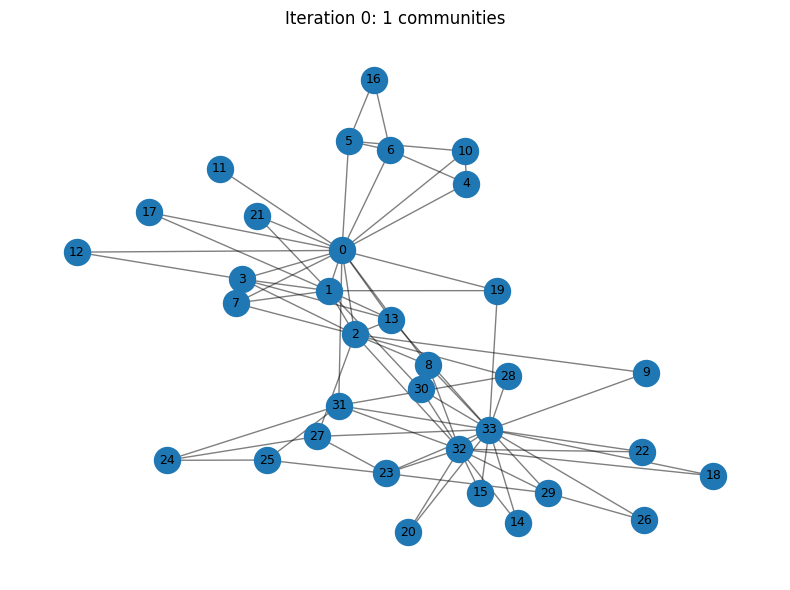

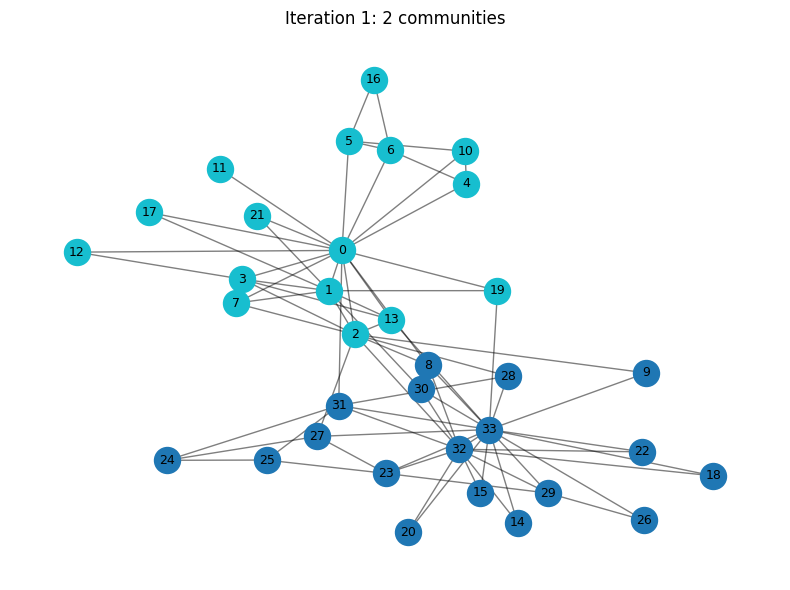

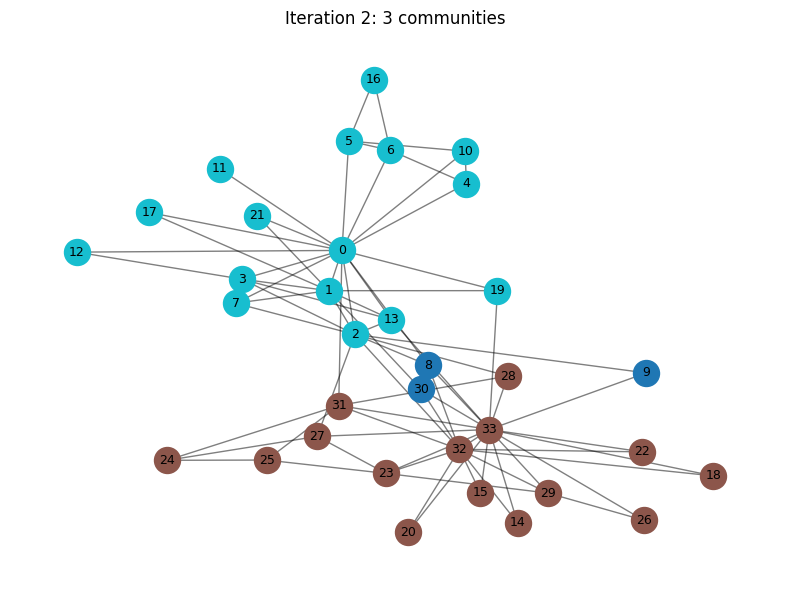

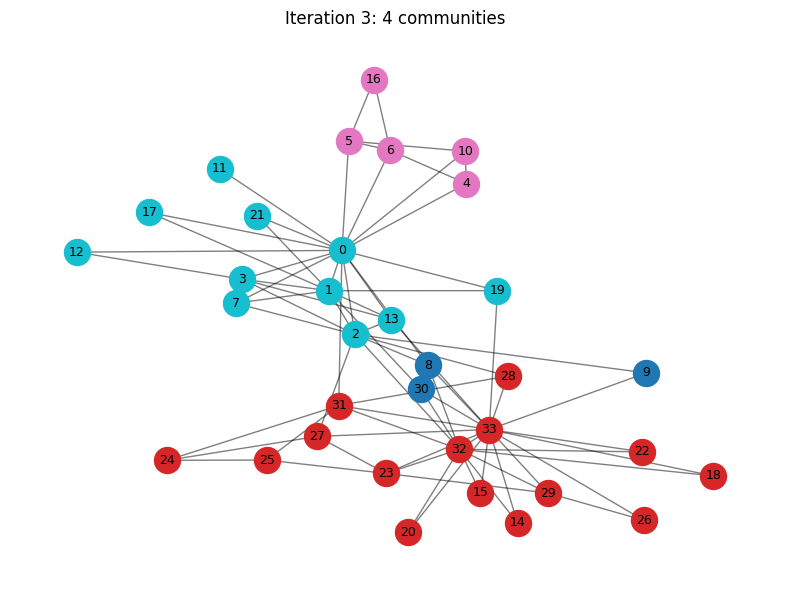

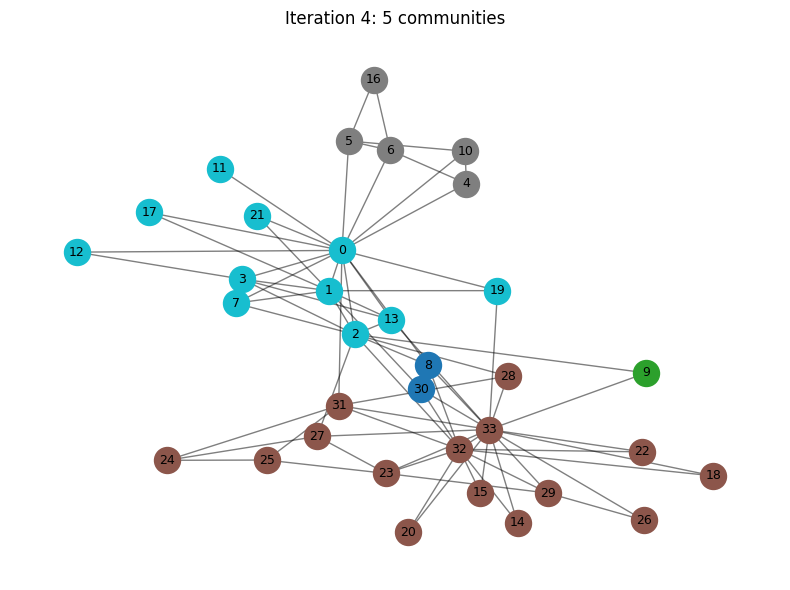

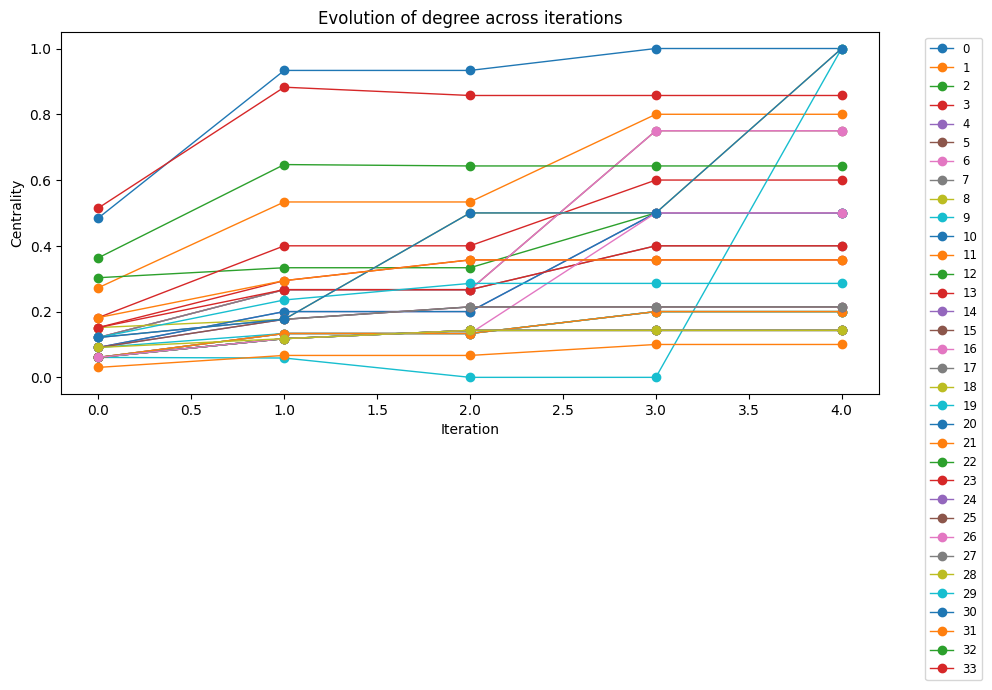

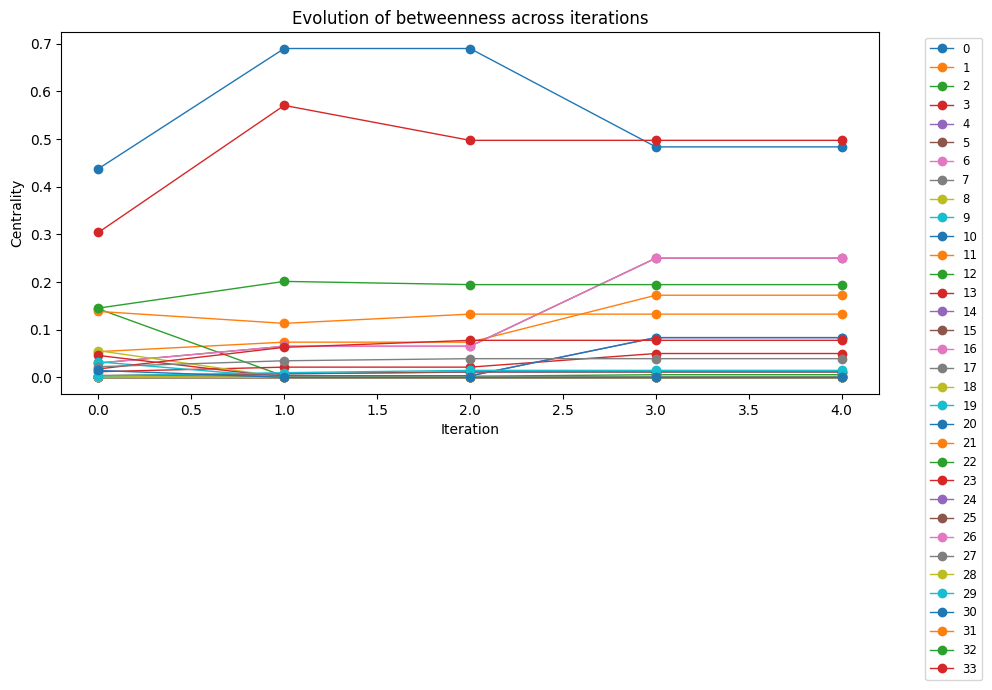

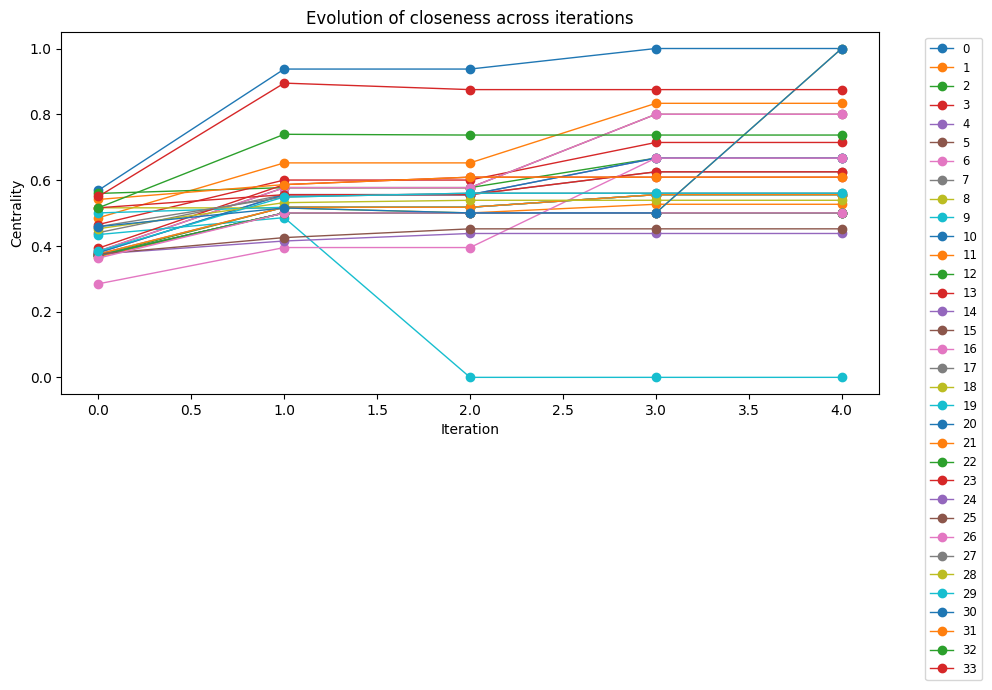

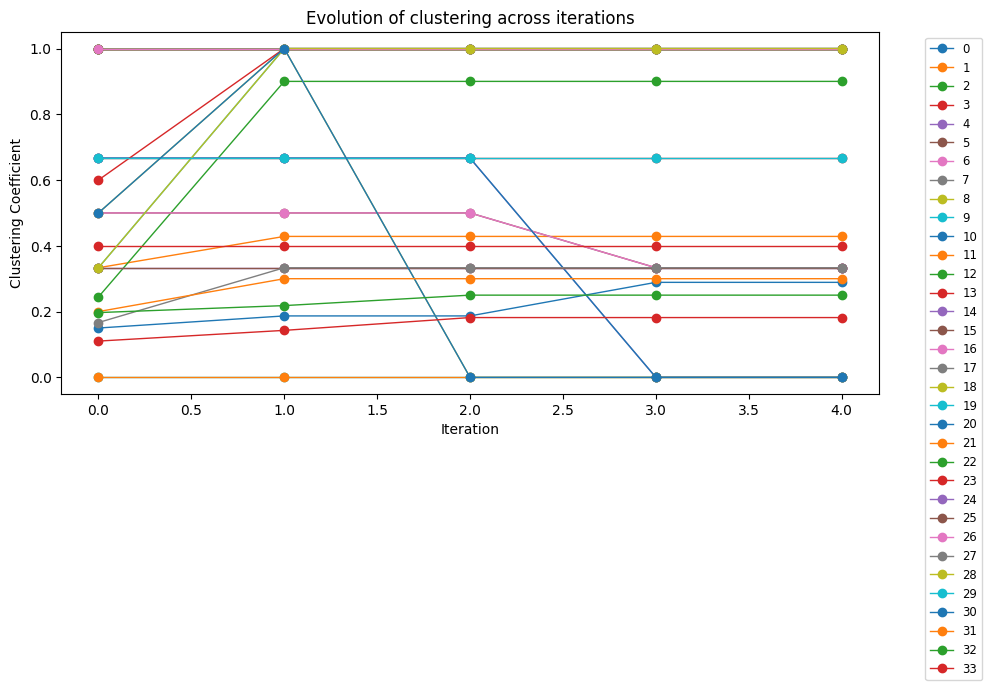


Short discussion:
Top degree: [(0, np.float64(0.8703030303030304)), (33, np.float64(0.7937866055513114)), (1, np.float64(0.5878787878787879)), (32, np.float64(0.5878533231474408)), (8, np.float64(0.46559714795008916))]
Top betweenness: [(0, np.float64(0.5567334054834056)), (33, np.float64(0.4731253808827338)), (32, np.float64(0.18599781754193517)), (5, np.float64(0.13202922077922077)), (6, np.float64(0.13202922077922077))]
Top closeness: [(0, np.float64(0.8887931034482758)), (33, np.float64(0.8139473684210525)), (32, np.float64(0.6930563501144165)), (1, np.float64(0.6912617220801365)), (5, np.float64(0.6275134168157424))]
Top clustering: [(7, np.float64(1.0)), (12, np.float64(1.0)), (14, np.float64(1.0)), (15, np.float64(1.0)), (16, np.float64(1.0))]


In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from itertools import count
from collections import defaultdict, deque
import math
import os

np.random.seed(0)

os.makedirs('/mnt/data/dsc212_outputs', exist_ok=True)

# -------------------------------------------
# Modularity matrix from graph
# -------------------------------------------
def modularity_matrix_from_graph(G):
    """Return the modularity matrix B = A - k k^T / (2m) for the full graph G."""
    n = G.number_of_nodes()
    nodes = list(G.nodes())
    idx = {node:i for i,node in enumerate(nodes)}
    A = nx.to_numpy_array(G, nodelist=nodes)
    k = A.sum(axis=1)
    m = A.sum() / 2.0
    if m == 0:
        raise ValueError('Graph has no edges.')
    kkT = np.outer(k, k) / (2.0*m)
    B = A - kkT
    return B, nodes, idx, int(m)

# -------------------------------------------
# Restricted modularity matrix
# -------------------------------------------
def restricted_B(B_full, nodes_full, idx_full, node_subset):
    inds = [idx_full[n] for n in node_subset]
    return B_full[np.ix_(inds, inds)], inds

# -------------------------------------------
# Leading eigenpair
# -------------------------------------------
def leading_eigenpair(B):
    w, v = np.linalg.eigh(B)
    return w[-1], v[:, -1]

# -------------------------------------------
# Recursive spectral bisection
# -------------------------------------------
def recursive_bisection(G):
    B_full, nodes_full, idx_full, m = modularity_matrix_from_graph(G)

    initial = sorted(list(G.nodes()))
    communities = [initial]
    snapshots = [list(map(sorted, communities.copy()))]
    splits_info = []
    queue = deque([initial])

    while queue:
        C = queue.popleft()
        if len(C) <= 1:
            continue

        Bc, inds = restricted_B(B_full, nodes_full, idx_full, C)
        lambda1, u1 = leading_eigenpair(Bc)

        if lambda1 <= 0:
            continue

        C_plus = [C[i] for i, val in enumerate(u1) if val > 0]
        C_minus = [C[i] for i, val in enumerate(u1) if val <= 0]

        if len(C_plus) == 0 or len(C_minus) == 0:
            continue

        try:
            idx_replace = next(i for i,comm in enumerate(communities) if set(comm)==set(C))
        except StopIteration:
            continue

        communities.pop(idx_replace)
        communities.insert(idx_replace, sorted(C_minus))
        communities.insert(idx_replace+1, sorted(C_plus))

        splits_info.append({
            'parent': sorted(C),
            'plus': sorted(C_plus),
            'minus': sorted(C_minus),
            'lambda1': float(lambda1)
        })

        snapshots.append(list(map(sorted, communities.copy())))
        queue.append(sorted(C_minus))
        queue.append(sorted(C_plus))

    return snapshots, splits_info

# -------------------------------------------
# Compute metrics evolution
# -------------------------------------------
def compute_metrics_per_iteration(G, snapshots):
    metrics = ['degree', 'betweenness', 'closeness', 'clustering']
    metrics_history = {metric: {n: [] for n in G.nodes()} for metric in metrics}

    for iteration, communities in enumerate(snapshots):
        for comm in communities:
            sub = G.subgraph(comm).copy()

            deg = nx.degree_centrality(sub)
            btw = nx.betweenness_centrality(sub, normalized=True) if sub.number_of_nodes()>1 else {n:0.0 for n in sub.nodes()}
            clo = nx.closeness_centrality(sub) if sub.number_of_nodes()>1 else {n:0.0 for n in sub.nodes()}
            clust = nx.clustering(sub) if sub.number_of_nodes()>1 else {n:0.0 for n in sub.nodes()}

            for n in sub.nodes():
                metrics_history['degree'][n].append(deg.get(n, 0.0))
                metrics_history['betweenness'][n].append(btw.get(n, 0.0))
                metrics_history['closeness'][n].append(clo.get(n, 0.0))
                metrics_history['clustering'][n].append(clust.get(n, 0.0))

        for metric in metrics:
            for n in G.nodes():
                if len(metrics_history[metric][n]) < iteration+1:
                    metrics_history[metric][n].append(0.0)

    return metrics_history

# -------------------------------------------
# FINAL VISUALIZATION FUNCTION WITH COMMUNITY COLORS
# -------------------------------------------
def visualize_snapshots(G, snapshots, splits_info, fixed_pos=None, figsize=(8,6)):
    if fixed_pos is None:
        fixed_pos = nx.spring_layout(G, seed=0)

    figs = []
    for i, communities in enumerate(snapshots):
        plt.figure(figsize=figsize)

        num_communities = len(communities)
        cmap = plt.cm.get_cmap('tab20', num_communities) if num_communities > 10 else plt.cm.get_cmap('tab10', num_communities)

        for j, comm in enumerate(communities):
            nx.draw_networkx_nodes(
                G,
                pos=fixed_pos,
                nodelist=comm,
                node_size=350,
                node_color=cmap(j),
                label=f'c{j+1}'
            )

        nx.draw_networkx_edges(G, pos=fixed_pos, alpha=0.5)
        nx.draw_networkx_labels(G, pos=fixed_pos, font_size=9)

        plt.title(f'Iteration {i}: {len(communities)} communities')
        plt.axis('off')
        plt.tight_layout()

        fname = f'/mnt/data/dsc212_outputs/karate_iteration_{i}.png'
        plt.savefig(fname, dpi=150)
        figs.append(fname)

        plt.show()

    return figs

# -------------------------------------------
# Plot metric evolution
# -------------------------------------------
def plot_metrics_evolution(metrics_history, snapshots):
    iterations = list(range(len(snapshots)))
    metric_names = list(metrics_history.keys())

    for metric in metric_names:
        plt.figure(figsize=(10,6))
        for n, series in metrics_history[metric].items():
            if len(series) < len(iterations):
                series = series + [series[-1]]*(len(iterations)-len(series))
            plt.plot(iterations, series, marker='o', linewidth=1, label=str(n))

        plt.xlabel('Iteration')
        plt.ylabel('Centrality' if metric!='clustering' else 'Clustering Coefficient')
        plt.title(f'Evolution of {metric} across iterations')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
        plt.tight_layout()

        fname = f'/mnt/data/dsc212_outputs/metric_{metric}.png'
        plt.savefig(fname, dpi=150)
        plt.show()

# -------------------------------------------
# RUN EVERYTHING END-TO-END
# -------------------------------------------
G = nx.karate_club_graph()

snapshots, splits_info = recursive_bisection(G)
print(f'Total iterations: {len(snapshots)}')

for i, s in enumerate(snapshots):
    print(f'Iteration {i}: {len(s)} communities — sizes: {[len(c) for c in s]}')

metrics_history = compute_metrics_per_iteration(G, snapshots)
fixed_pos = nx.spring_layout(G, seed=0)

fig_files = visualize_snapshots(G, snapshots, splits_info, fixed_pos=fixed_pos)
plot_metrics_evolution(metrics_history, snapshots)

# Short analysis
print("\nShort discussion:")
avg_deg = {n: np.mean(v) for n, v in metrics_history['degree'].items()}
print("Top degree:", sorted(avg_deg.items(), key=lambda x: -x[1])[:5])

avg_btw = {n: np.mean(v) for n, v in metrics_history['betweenness'].items()}
print("Top betweenness:", sorted(avg_btw.items(), key=lambda x: -x[1])[:5])

avg_clo = {n: np.mean(v) for n, v in metrics_history['closeness'].items()}
print("Top closeness:", sorted(avg_clo.items(), key=lambda x: -x[1])[:5])

avg_clust = {n: np.mean(v) for n, v in metrics_history['clustering'].items()}
print("Top clustering:", sorted(avg_clust.items(), key=lambda x: -x[1])[:5])